In [1]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [6]:
%matplotlib
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_classif, chi2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve

Using matplotlib backend: nbAgg


In [3]:
pd.options.display.max_columns = None

In [28]:
# Brett's directory
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

# Split the target variable based on the median value
medianSplit = dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfPublicHS['schoolPctTarget'] = np.where(dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= medianSplit, 1, 0)

print("Median: {}".format(medianSplit))
print("{} of {}: {}%".format(dfPublicHS['schoolPctTarget'].sum(), dfPublicHS.shape[0], 
                             round(dfPublicHS['schoolPctTarget'].sum()/dfPublicHS.shape[0] * 100,2)))

# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings

# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct')

dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

# Data
X = dfPublicHS.iloc[:,0:dfPublicHS.shape[1] - 2]

# Target class
y = dfPublicHS['schoolPctTarget']

X.shape

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
Columns Dropped: 1
Median: 52.178614549748545
235 of 470: 50.0%


(470, 395)

## Feature Selection

### Chi2 and ANOVA Test

In [32]:
p = 40
X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
print('Chi2 selected {} features.'.format(chi2_selected.sum()))

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X.columns) if f_classif_selected[i]]
print('F_classif selected {} features.'.format(f_classif_selected.sum()))

selected = chi2_selected & f_classif_selected
print('Intersection of Chi2 & F_classif: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

Chi2 selected 158 features.
F_classif selected 158 features.
Intersection of Chi2 & F_classif: 134 features


### Recursive Feature Elimination (RFE)

Through the use of a shallow RandomForest classifier, we can determine which attributes have the most affect on class seperation. Through the use of RFE it was determined that 34 attributes had the most significant impact on class prediction. This resulted in a number of attributes that was much more manageable.

<IPython.core.display.Javascript object>


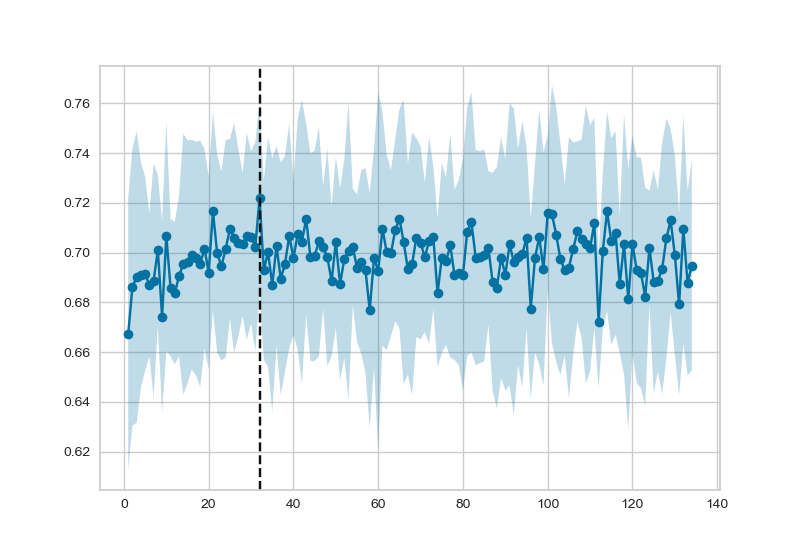

Wall time: 16min
The optimal number of features is 32
The selected features are:
['ACTScience_ACTBenchmark_Male', 'ACTWriting_ACTBenchmark_Male', 'EOCBiology_CACR_Male', 'EOCEnglish2_CACR_Male', 'EOCMathI_CACR_Male', 'GraduationRate_4yr_Male', 'GraduationRate_5yr_Male', 'ACTCompositeScore_UNCMin_Asian', 'EOCEnglish2_CACR_Asian', 'EOCSubjects_CACR_Asian', 'EOCMathI_CACR_Black', 'ACTCompositeScore_UNCMin_White', 'ACTMath_ACTBenchmark_White', 'ACTScience_ACTBenchmark_White', 'ACTSubtests_BenchmarksMet_White', 'ACTWriting_ACTBenchmark_EDS', 'GraduationRate_4yr_LEP', 'ACTWriting_ACTBenchmark_SWD', 'ACTCompositeScore_UNCMin_AIG', 'ACTWriting_ACTBenchmark_AIG', 'EOCBiology_CACR_AIG', 'EOCEnglish2_CACR_AIG', 'EOCMathI_CACR_AIG', 'GraduationRate_4yr_AIG', 'sat_avg_score_num', 'ap_participation_pct', 'ap_pct_3_or_above', 'cte_courses', 'short_susp_per_c_num', 'tchyrs_0thru3_pct', 'lateral_teach_pct', 'lea_tchyrs_0thru3_pct']


In [13]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

cv = ShuffleSplit(n_splits=10, test_size  = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, stratify=y, test_size=.2)

selector = RFECV(RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=42), cv=cv, scoring='f1_weighted')
time selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]

# May remove

<IPython.core.display.Javascript object>


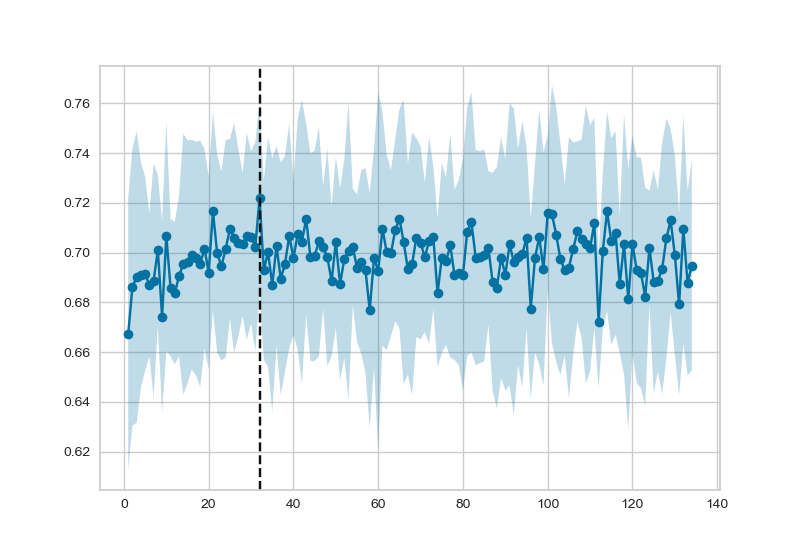

Wall time: 18min 25s
The optimal number of features is 32
The selected features are:
['ACTScience_ACTBenchmark_Male', 'ACTWriting_ACTBenchmark_Male', 'EOCBiology_CACR_Male', 'EOCEnglish2_CACR_Male', 'EOCMathI_CACR_Male', 'GraduationRate_4yr_Male', 'GraduationRate_5yr_Male', 'ACTCompositeScore_UNCMin_Asian', 'EOCEnglish2_CACR_Asian', 'EOCSubjects_CACR_Asian', 'EOCMathI_CACR_Black', 'ACTCompositeScore_UNCMin_White', 'ACTMath_ACTBenchmark_White', 'ACTScience_ACTBenchmark_White', 'ACTSubtests_BenchmarksMet_White', 'ACTWriting_ACTBenchmark_EDS', 'GraduationRate_4yr_LEP', 'ACTWriting_ACTBenchmark_SWD', 'ACTCompositeScore_UNCMin_AIG', 'ACTWriting_ACTBenchmark_AIG', 'EOCBiology_CACR_AIG', 'EOCEnglish2_CACR_AIG', 'EOCMathI_CACR_AIG', 'GraduationRate_4yr_AIG', 'sat_avg_score_num', 'ap_participation_pct', 'ap_pct_3_or_above', 'cte_courses', 'short_susp_per_c_num', 'tchyrs_0thru3_pct', 'lateral_teach_pct', 'lea_tchyrs_0thru3_pct']


In [14]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=42, oob_score=True, n_jobs=-1), 
                 cv=cv, scoring='f1_weighted')
%time selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]

### Pearson Correlation Evaluation

The remaining attributes were ranked to determine if any remaining attributes were highly correlated. There appears to be some correlation between ACT_Benchmark_White attributes but we will leave them in the model for now and assess how the models perform with them.

<IPython.core.display.Javascript object>


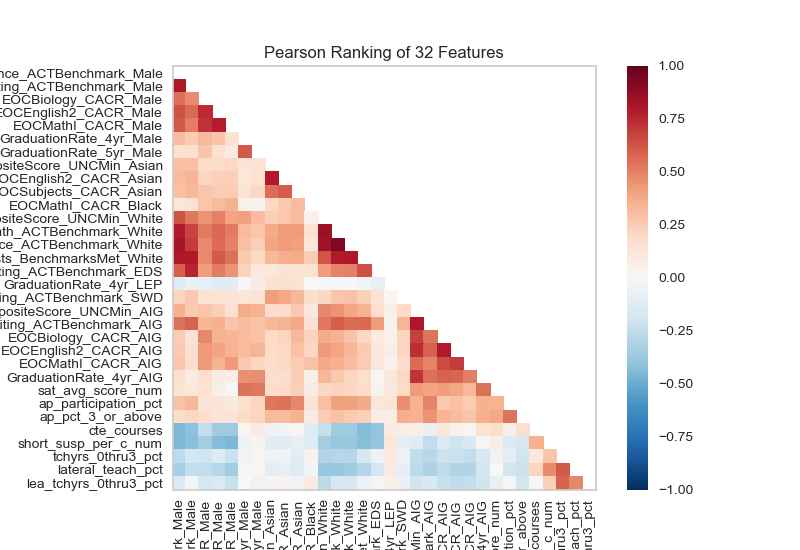

In [16]:
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=features, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[features], y)
vis.transform(dfPublicHS[features])
vis.poof()

### Feature Evaluation

Using the GradiantBoostingClassifier and RidgeClassifer we look at the impact of each attribute as a classifier.

<IPython.core.display.Javascript object>


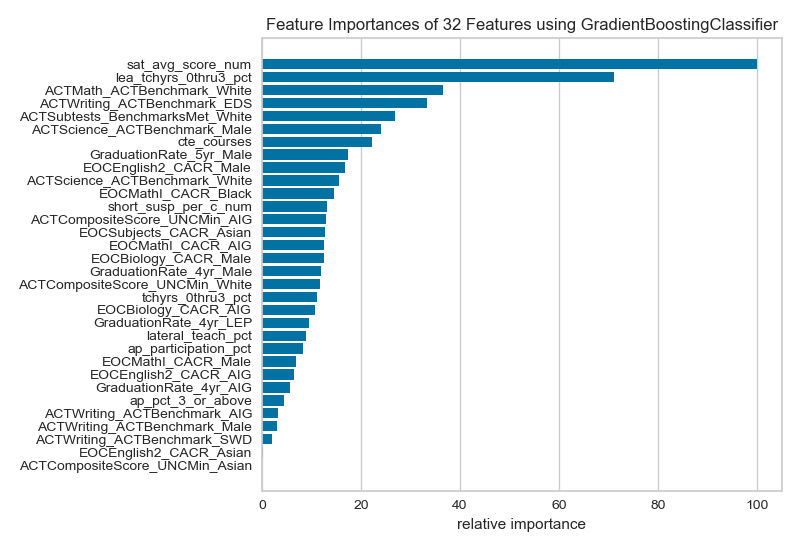

In [36]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(dfPublicHS[features], y)
viz.poof()

<IPython.core.display.Javascript object>


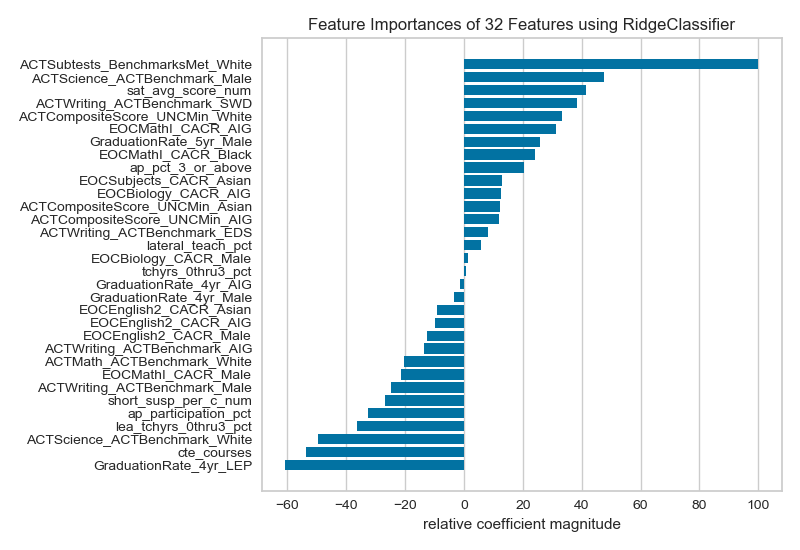

In [135]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RidgeClassifier(), ax=ax)
viz.fit(dfPublicHS[features], y)
viz.poof()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, random_state=42, stratify=y, test_size=.2)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(X_train)
xTrain = scaler.transform(X_train)
xTest = scaler.transform(X_test)

### Hyperparamter Selection

Based on the validation curve, we see the model starts to overgeneralize between 10e-6 and 10e-4. We use these values to further define where we should set our start and stop gamma values to determine the best value to use in our model.

<IPython.core.display.Javascript object>


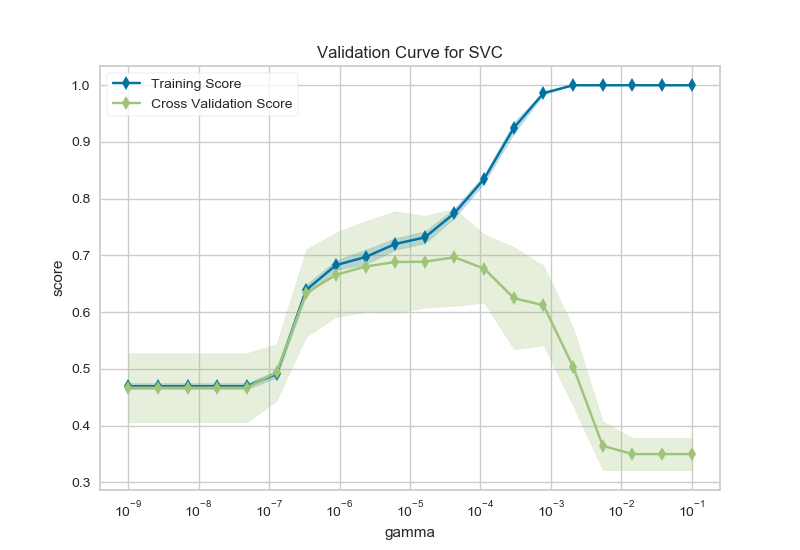

In [38]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
cv = StratifiedKFold(12)
param_range = np.logspace(-9, -1, 20)

viz = ValidationCurve(
    SVC(), param_name="gamma", param_range=param_range,
    logx=True, cv=cv, scoring="f1_weighted", n_jobs=8,
)

viz.fit(X_train, y_train)
viz.poof()

In [39]:
# Set parameter turning values and create a grid of models to run
gamma_opts = np.logspace(-6, -4, num = 20)
param_grid = dict(gamma=gamma_opts, C=[1,10,100,1000])
cv = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
gridRBF = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

### Training and Performance

In [ ]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
gridRBF.fit(X_train, y_train)

bestValues = gridRBF.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

classFit = cls.fit(X_train, y_train)

y_hat = cls.predict(X_test)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test)

cm.score(X_test, y_test)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train, y_train)

# Evaluate the model on the test data
vis.score(X_test, y_test)

# Draw visualization
vis.poof()

# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

Training started at: 22:47:04.030312


### Conclusion

Using the 32 attributes we determined were most likely the best predictors, we were able to acheive an accuracy of 74%. Our recall and precision scores indicate that we misclassify equally. The recall score indicates that we falsely classify a school as acheiving above 52% postsecondary enrollment 25% of the time. A similar result of falsely classifying a school as acheiving below 52% postsecondary enrollment. Ideally we would like to acheive better prediction results but since we are looking at the percentage of student postsecondary enrollment a misclassification would not have the same kind of impact as trying to predict cancer in a patient. 

## Model built on the 134 identified attributes originally

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, stratify=y, test_size=.2)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(X_train)
xTrain = scaler.transform(X_train)
xTest = scaler.transform(X_test)

Training started at: 19:44:26.841662
Best parameters set found on development set: {'C': 1, 'gamma': 1.438449888287663e-05}


<IPython.core.display.Javascript object>


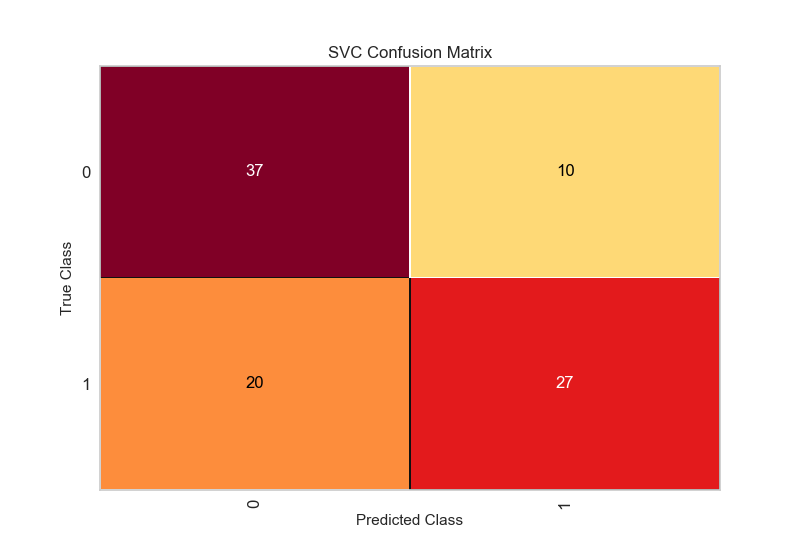

<IPython.core.display.Javascript object>


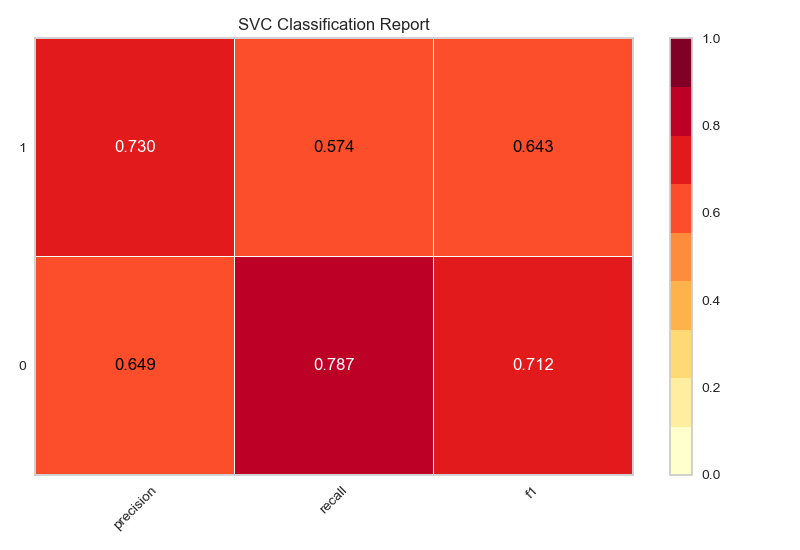

<IPython.core.display.Javascript object>


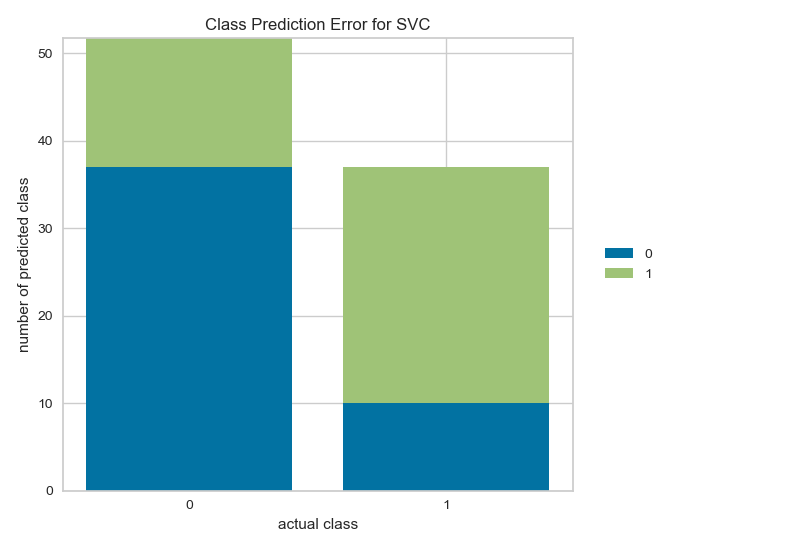

In [27]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
gridRBF.fit(X_train, y_train)

bestValues = gridRBF.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

# Train
cm = ConfusionMatrix(cls.fit(X_train, y_train))

# Predict test values
cm.predict(X_test)

cm.score(X_test, y_test)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = ClassificationReport(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Instantiate the classification model and visualizer
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train, y_train)

# Evaluate the model on the test data
vis.score(X_test, y_test)

# Draw visualization
vis.poof()
